# Install related packages

In [1]:
!pip install -r requirements.txt

# Load the input data using PySpark

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Email-Spam-Classification").getOrCreate()

24/09/22 23:31:06 WARN Utils: Your hostname, KhoiVNMacbook.local resolves to a loopback address: 127.0.0.1; using 192.168.30.111 instead (on interface en0)
24/09/22 23:31:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/22 23:31:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.option("header", True).csv('data/emails.csv')
df.show()
df.count()

24/09/22 23:31:31 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---------+---+---+---+---+---+---+---+---+---+---+---+---+----+-----+---+---+----+----+----+----+----+---+---+---+---+---+---+---+---+----+---+---+---+---+----+---+-----+---+------+---+---+---+---+----+---+---+---+---+---+----+----+---+---------+---+---+---+---+---+-----+------+---+---+---+---+---+---+-----+-----+-----+---+----+-------+---+-----+---+---+-----+---+----+---+------+--------+---+-----------+----+-------+---+----+---+---+----+----+----+---+------+----+--------+-----+-----+----+------+------+-----+-----+---+------+---+---------+---+-----+-------+---+---+---+-----+----+----+-----+----+----+----+------+-----+----+----+---+----+---+---------+---+----------+----+----+----+----+--------+----+-----+---+------+---+---+-----+----+---+------+-----+-------+----+----+----+----------+------+---+-----+------+----+---+---+-----+------+--------+----+---+-------+----+-------+----+----+-----+---+-----+-----+---+---+---+---+-----+----------+---+----+---+----+-----+---+---------+----+-------+

5172

# Pre-processing

In [4]:
df.dropDuplicates()
df.printSchema()

root
 |-- Email No.: string (nullable = true)
 |-- the: string (nullable = true)
 |-- to: string (nullable = true)
 |-- ect: string (nullable = true)
 |-- and: string (nullable = true)
 |-- for: string (nullable = true)
 |-- of: string (nullable = true)
 |-- a: string (nullable = true)
 |-- you: string (nullable = true)
 |-- hou: string (nullable = true)
 |-- in: string (nullable = true)
 |-- on: string (nullable = true)
 |-- is: string (nullable = true)
 |-- this: string (nullable = true)
 |-- enron: string (nullable = true)
 |-- i: string (nullable = true)
 |-- be: string (nullable = true)
 |-- that: string (nullable = true)
 |-- will: string (nullable = true)
 |-- have: string (nullable = true)
 |-- with: string (nullable = true)
 |-- your: string (nullable = true)
 |-- at: string (nullable = true)
 |-- we: string (nullable = true)
 |-- s: string (nullable = true)
 |-- are: string (nullable = true)
 |-- it: string (nullable = true)
 |-- by: string (nullable = true)
 |-- com: string 

In [5]:
df = df.drop('Email No.')
df.fillna(0)
df.show()

+---+---+---+---+---+---+---+---+---+---+---+---+----+-----+---+---+----+----+----+----+----+---+---+---+---+---+---+---+---+----+---+---+---+---+----+---+-----+---+------+---+---+---+---+----+---+---+---+---+---+----+----+---+---------+---+---+---+---+---+-----+------+---+---+---+---+---+---+-----+-----+-----+---+----+-------+---+-----+---+---+-----+---+----+---+------+--------+---+-----------+----+-------+---+----+---+---+----+----+----+---+------+----+--------+-----+-----+----+------+------+-----+-----+---+------+---+---------+---+-----+-------+---+---+---+-----+----+----+-----+----+----+----+------+-----+----+----+---+----+---+---------+---+----------+----+----+----+----+--------+----+-----+---+------+---+---+-----+----+---+------+-----+-------+----+----+----+----------+------+---+-----+------+----+---+---+-----+------+--------+----+---+-------+----+-------+----+----+-----+---+-----+-----+---+---+---+---+-----+----------+---+----+---+----+-----+---+---------+----+-------+----+----+

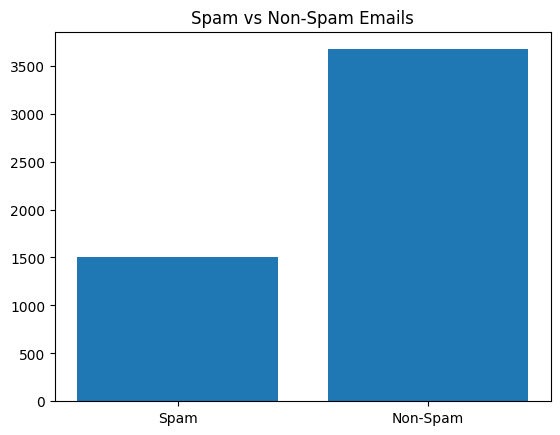

In [6]:
spam = df.filter(df['Prediction'] == 1)
non_spam = df.filter(df['Prediction'] == 0)
plt.bar(['Spam', 'Non-Spam'], [spam.count(), non_spam.count()])
plt.title('Spam vs Non-Spam Emails')
plt.show()

In [7]:
df_words = df.drop('Prediction')
df_pred = df.select('Prediction')

# Tokenization and embedding

In [8]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim.downloader as downloader

stop_words = set(stopwords.words('english'))
wave2vec_model = downloader.load('glove-wiki-gigaword-100')

def remove_stopwords(words):
    return [word for word in words if word.lower() not in stop_words]

def get_word_vector(words, model):
    embeddings = [model[word] for word in words if word in model]
    if embeddings:
        return sum(embeddings) / len(embeddings)
    else:
        return np.zeros(100)


[nltk_data] Downloading package stopwords to /Users/macos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/macos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
df_words = df_words.toPandas()
df_words["embeddings"] = None
for i, row in df_words.iterrows():
    words = row.sort_values(ascending=False)[:50].index.tolist()
    words_ = remove_stopwords(words)
    embeddings = get_word_vector(words_, wave2vec_model)
    df_words.at[i, "embeddings"] = embeddings

df_words["embeddings"][:10].to_csv('data/emails_embeddings.csv', index=True)

# Clustering

In [10]:
# Clustering with KMeans and PCA

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

X = np.array(df_words["embeddings"].tolist())
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)
print(X_pca.shape)

(5172, 3)


/Users/macos/miniconda3/envs/ds1/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/macos/miniconda3/envs/ds1/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/macos/miniconda3/envs/ds1/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/macos/miniconda3/envs/ds1/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The defa

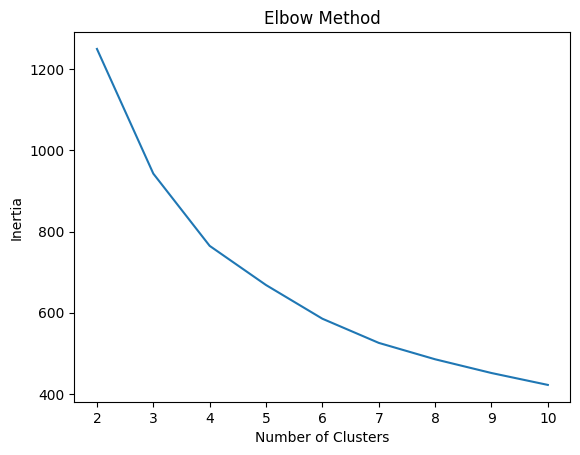

In [11]:
# Plotting the Inertia to find the optimal number of clusters
inertias = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X_pca)
    inertias.append(kmeans.inertia_)

plt.plot(range(2, 11), inertias)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

Identify the optimal number of clusters for a K-Means clustering model. The x-axis represents the number of clusters (k), while the y-axis shows inertia, which measures the compactness of the clusters. As the number of clusters increases, inertia decreases because more clusters generally result in tighter groups. The "elbow" in the curve—where the rate of decrease slows down—indicates the ideal number of clusters. In this case, the elbow appears around 4 or 5 clusters, suggesting that adding more clusters beyond this point offers diminishing returns in improving clustering quality.

# Classification

In [12]:
# Classification

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import xgboost as xgb

df_pred = df_pred.toPandas()
X_train, X_test, y_train, y_test = train_test_split(X, df_pred.astype(int), test_size=0.2, random_state=42)

model = xgb.XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93       739
           1       0.84      0.78      0.81       296

    accuracy                           0.89      1035
   macro avg       0.88      0.86      0.87      1035
weighted avg       0.89      0.89      0.89      1035



With simple pre-processing, we have class 0, the model has a precision of 0.91, recall of 0.94, and an F1-score of 0.93, based on 739 instances. And class 1, the model has a precision of 0.84, recall of 0.78, and an F1-score of 0.81, based on 296 instances. The overall accuracy of the model is 0.89, meaning it correctly classified 89% of the total 1,035 instances.

In [24]:
from collections import Counter, defaultdict

df_pred["Prediction"] = df_pred["Prediction"].astype(int)

def get_top_words_by_category(df, df_pred):
    spam_word_counts = defaultdict(int)
    non_spam_word_counts = defaultdict(int)
    
    for i, row in df.iterrows():
        prediction = df_pred.at[i, "Prediction"]
        for word, count in row.items():
            if prediction == 1:
                spam_word_counts[word] += count
            else:
                non_spam_word_counts[word] += count
    
    top_spam_words = dict(Counter(spam_word_counts).most_common(10))
    top_non_spam_words = dict(Counter(non_spam_word_counts).most_common(10))
    
    return top_spam_words, top_non_spam_words

top_spam_words, top_non_spam_words = get_top_words_by_category(df_words, df_pred)
print(top_spam_words)
print(top_non_spam_words)

TypeError: unsupported operand type(s) for +=: 'int' and 'str'

The error seems to be data type when loading with PySpark that use default value for the schema is string. The error can be fixed by specifying the schema with the correct data type.